# Magic State Distillation

While many typical quantum algorithms can be described via simple quantum circuits, others require a more expressive programming model. Beyond the description of unitary operators, an algorithm may require the probabilistic execution of quantum instructions, real-time feedback from quantum measurements, real-time classical computation, and unbounded repetitions of program segments. Such programs are generally also called **hybrid (classical-)quantum programs**.

[Catalyst](https://xanaduai-pennylane-mlir.readthedocs-hosted.com/en/latest/) for PennyLane brings this powerful programming model to PennyLane to develop and compile hybrid quantum programs in Python. One such algorithm that goes beyond the circuit model is the **magic state distillation** routine, developed to enable practical universal gate sets on fault-tolerant hardware architectures. In this tutorial, we will see how we can use Catalyst's tight integration of quantum and classical code, both within the language and during execution, to develop a magic state distillation routine. 

## Primer

The idea behind this algorithm is based on the availability of a quantum computer that is only capable of running gates from the *Clifford group*, which is generated by the operators $\{H, S, CNOT\}$. This computer alone is provably not a universal quantum computer, meaning that there are quantum algorithms it would not be capable of running.

In order to achieve universal quantum computing, only a single additional "non-Clifford" gate is required, which cannot be constructed from Clifford gates alone. As demonstrated by [Bravyi and Kitaev in 2005](https://arxiv.org/abs/quant-ph/0403025), certain noisy qubit states can be purified into so-called *magic states*, which can in turn be used to implement non-Clifford gates by consuming the magic state. 

In practice, it is not necessarily easy to generate magic states. However, provided we have a method of generating (noisy) quantum states that are just "close enough" to magic states, we can purify the noisy states to be arbitrarily close to ideal magic states. This is the procedure performed by the magic state distillation algorithm.


## T-Type Magic States

In this tutorial we will produce T-type magic states via purification.
T-type states are a particular type of magic states that are defined as the eigenvectors of the $e^{i\pi/4}SH$ operator (an $H$ gate followed by an $S$ gate):

$$\frac{e^{i\pi/4}}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ i & -i \end{bmatrix}$$

In the computational basis, these eigenvectors can be expressed as:

$$| T_0\rangle = \cos(\beta) | 0\rangle + e^{i\pi/4}\sin(\beta) | 1\rangle,$$
$$| T_1\rangle = \sin(\beta)| 0\rangle - e^{i\pi/4}\cos(\beta)| 1\rangle,$$

with $\beta = \frac{1}{2}\arccos(\frac{1}{\sqrt{3}})$.

First, let's set up a faulty $| T_0\rangle$ state-generating function:

In [1]:
import pennylane as qml
import jax; jax.config.update('jax_platform_name', 'cpu')
from jax import numpy as jnp
from jax import random

b = (1/2)*jnp.arccos(1/jnp.sqrt(3))

def generate_T0(wire):
    """Generate a pure |T₀⟩ state via a Y-rotation and phase shift.
    
       |T₀⟩ = cos(β)|0⟩ + e^iπ/4 sin(β)|1⟩
    """
    qml.RY(2*b, wires=wire)
    qml.PhaseShift(jnp.pi/4, wires=wire)

def faulty_generate_T0(wire, key, r):
    """A faulty |T₀⟩ state generator that adds a random component of scale `r` to the |T₀⟩ state,
       meaning to the angular components θ and φ of the Bloch sphere representation:

        |ψ⟩ = cos(θ)|0⟩ + e^(iφ) sin(θ)|1⟩.
    
       Since this is a random function, we need to pass it a PRNG key to satisfy JAX's stateless
       implementation.
    """
    key, subkey = random.split(key)
    disturbance = random.uniform(subkey, minval=-r, maxval=r)
    qml.RY(2*(b + disturbance), wires=wire)
    key, subkey = random.split(key)
    disturbance = random.uniform(subkey, minval=-r, maxval=r)
    qml.PhaseShift(jnp.pi/4 + disturbance, wires=wire)
    return key

## Purification algorithm

The purification algorithm for magic states was first introduced by [Bravyi and Kitaev](https://arxiv.org/abs/quant-ph/0403025), although we will be using the implementation described in [A study of the robustness of magic state distillation against Clifford gate faults](https://uwspace.uwaterloo.ca/bitstream/handle/10012/6976/Jochym-O%27Connor_thesis_Final.pdf?sequence=1&isAllowed=y)  by Tomas Jochym-O'Connor. The process is as follows:

- prepare five copies of noisy $| T_0\rangle$ states;
- apply the decoding circuit of the 5-qubit error correction code (refer to the sources for why this works);
- perform a "syndrome" measurement on the first four wires (this is error correction terminology, normally meaning a measurement to detect the presence of errors).

Remarkably, if all the measurements come out as 0, we will have obtained a noisy $| T_1\rangle$ state of provably higher fidelity than our input states. We can then convert the $| T_1\rangle$ state into a $| T_0\rangle$ state using our Clifford gate set, namely a Hadamard gate followed by a Pauli-Y gate. This process can then be repeated to achieve even higher fidelities.

Note that if any of the measurements produced a 1, the algorithm failed and we need to restart the process. This is where the hybrid quantum programming features come in: we need to obtain real-time measurement results, and based on those decide on the next quantum instructions to execute.

First, let's define the error correction decoding circuit.

In [2]:
def error_correction_decoder(wires):
    """Error correction decoder for the 5-qubit error correction code generated by stabilizers XZZXI, IXZZX, XIXZZ, ZXIXZ.
    """
    w0, w1, w2, w3, w4 = wires

    qml.CNOT(wires=[w1, w0])
    qml.CZ(wires=[w1, w0])
    qml.CZ(wires=[w1, w2])
    qml.CZ(wires=[w1, w4])

    qml.CNOT(wires=[w2, w0])
    qml.CZ(wires=[w2, w3])
    qml.CZ(wires=[w2, w4])

    qml.CNOT(wires=[w3, w0])

    qml.CNOT(wires=[w4, w0])
    qml.CZ(wires=[w4, w0])

    qml.PauliZ(wires=w0)
    qml.PauliZ(wires=w1)
    qml.PauliZ(wires=w4)

    qml.Hadamard(wires=w1)
    qml.Hadamard(wires=w2)
    qml.Hadamard(wires=w3)
    qml.Hadamard(wires=w4)

We'll also define some helper functions to perform a conditional reset of a qubit into the $| 0\rangle$ state, which we will use whenever the algorithm needs to restart.
Here we use a mid-circuit measurement and a classically-controlled Pauli-X gate using the new [cond](https://xanaduai-pennylane-mlir.readthedocs-hosted.com/en/latest/code/api/catalyst.cond.html) construction (although in this case the same could be achieved with a CNOT gate):

In [3]:
from catalyst import cond, measure

def measure_and_reset(wire):
    """
    Measure a wire and then reset it back to the |0⟩ state.
    """

    m = measure(wire)

    @cond(m)
    def conditional_flip():
        qml.PauliX(wires=wire)

    conditional_flip()

    return m

def conditional_reset(pred, wire):
    """Conditionally reset a wire back to the |0⟩ state based on a predicate."""

    @cond(pred)
    def conditional_reset():
        measure_and_reset(wire)

    conditional_reset()

Now we come to the main part of the algorithm, which we will JIT-compile using Catalyst!

The structure of the algorithm consists of a *repeat-until-success* loop. This means we execute a piece of code with a probabilistic outcome, and if the outcome is not the desired result, we go back and repeat the code until we do get the desired result. In our case the desired result is a syndrome measurement of 0. We'll encode this repeat-until-success loop with the new [while_loop](https://xanaduai-pennylane-mlir.readthedocs-hosted.com/en/latest/code/api/catalyst.while_loop.html) construct, which previously wasn't expressible in PennyLane:

In [4]:
from catalyst import qjit, while_loop

@qjit()
@qml.qnode(qml.device("lightning.qubit", wires=5))
def main_circuit(random_key, r):
    """The main entry point of the algorithm. The structure is as follows.
    In a loop, we generate 5 faulty qubit states, run the decoding algorithm on them,
    and then measure wires 1–4 in the computational basis.
    
    If they all come out as 0, we return the state of the 0th wire. Normally, one would then go on
    and use this wire in some quantum circuit to apply a non-Clifford gate.
    Note that the 0th wire will actually be in the |T₁⟩ state, so we can convert it first by
    applying a Hadamard gate followed by a Pauli-Y gate.
    """

    @while_loop(lambda repeat, _: repeat)
    def loop(repeat, key):

        key = faulty_generate_T0(0, key, r)
        key = faulty_generate_T0(1, key, r)
        key = faulty_generate_T0(2, key, r)
        key = faulty_generate_T0(3, key, r)
        key = faulty_generate_T0(4, key, r)

        error_correction_decoder(wires=(0, 1, 2, 3, 4))

        m1 = 0 + measure_and_reset(1)
        m2 = 0 + measure_and_reset(2)
        m3 = 0 + measure_and_reset(3)
        m4 = 0 + measure_and_reset(4)

        syndrome = m1 + m2 + m3 + m4 > 0

        conditional_reset(syndrome, wire=0)

        return syndrome, key

    loop(True, random_key)

    # change T1 state back to T0
    qml.Hadamard(wires=0)
    qml.PauliY(wires=0)

    return qml.state()

## Benchmark

To confirm that we are, in fact, successfully distilling T-type magic states, we will measure the fidelity of a purified magic state compared to the fidelity of the original noisy state (with respect to an ideal $| T_0\rangle$ state). The results are averaged over a number of runs to account for the randomness in the noise.

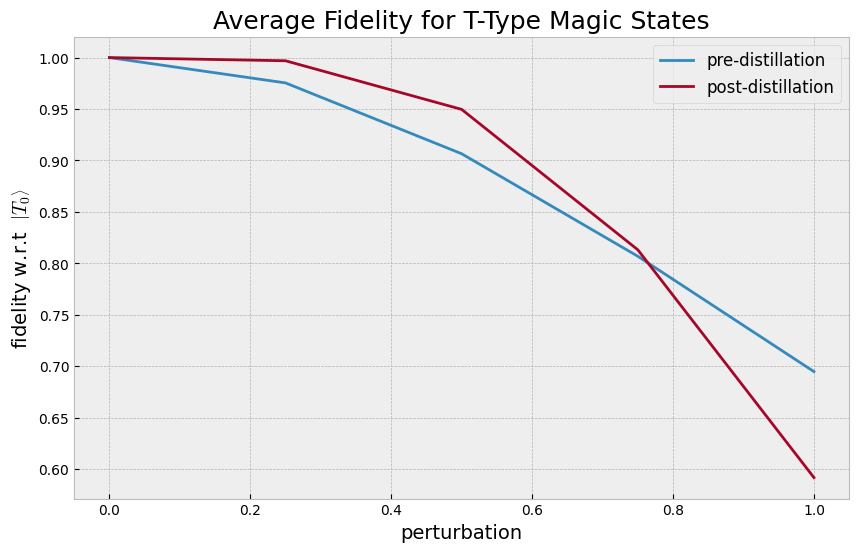

In [5]:
import matplotlib.pyplot as plt

dev_5_qubits = qml.device("default.qubit", wires=5)


@qml.qnode(dev_5_qubits)
def T0_state():
    generate_T0(0)
    return qml.state()

@qml.qnode(dev_5_qubits)
def faulty_T0_state(random_key, r):
    faulty_generate_T0(0, random_key, r)
    return qml.state()


exact_T0_state = T0_state()

xs = jnp.linspace(0, 1, 5)

pres = []
posts = []

TIMES = 200
for x in xs:
    
    pre_total = 0.
    post_total = 0.
    
    for i in range(TIMES):
        key = random.PRNGKey(i)
        
        faulty_qubit_state = faulty_T0_state(key, x)
        distilled_qubit_state = main_circuit(key, x)
        
        base_fidelity = jnp.abs(jnp.dot(faulty_qubit_state, jnp.conj(exact_T0_state))) ** 2
        pre_total += base_fidelity
        distilled_fidelity = jnp.abs(jnp.dot(distilled_qubit_state, jnp.conj(exact_T0_state))) ** 2
        post_total += distilled_fidelity
    
    pres.append(pre_total / TIMES)
    posts.append(post_total / TIMES)

plt.style.use("bmh")
plt.figure(figsize=(10, 6))
plt.plot(xs, pres, label="pre-distillation")
plt.plot(xs, posts, label="post-distillation")
plt.title("Average Fidelity for T-Type Magic States", fontsize=18)
plt.legend(fontsize=12)
plt.xlabel("perturbation", fontsize=14)
plt.ylabel(r"fidelity w.r.t  $\left|T_0\right\rangle$", fontsize=14)
plt.show()

From the plot we can see that the distillation procedure can significantly improve the fidelity of the magic state, provided that the input state has at least ~82% fidelity.


## Conclusion

In this tutorial, we have implemented the magic state distillation algorithm to distill a noisy T-type magic state into one of higher fidelity. This was done by decoding the $| T_0\rangle$ state with the 5-qubit error correction code, and selecting for the desired measurement outcomes.

This algorithm can be repeated many times, in order to obtain $| T_0\rangle$ states of arbitrary fidelity. Non-Clifford gates can then be implemented on a fault-tolerant architecture, achieving universal quantum computation.